In [1]:
conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cudatoolkit=11.3
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bzip2-1.0.8                |       h7f98852_4         484 KB  conda-forge
    ffmpeg-4.3                 |       hf484d3e_0         9.9 MB  pytorch
    gmp-6.2.1                  |       h58526e2_0         806 KB  conda-forge
    gnutls-3.6.13              |       h85f3911_1         2.0 MB  conda-forge
    lame-3.100                 |    h7f98852_1001         496 KB  conda-forge
    libiconv-1.17              |       h166bdaf_0         1.4 MB  conda-forge
    nettle-3.6                 |       he412f7d_0         6.5 MB  conda-forge
    openh264-2.1.1             |       h780b84a_0         1.5 MB  conda-forge
    torchaudio-0.11.0          |       py37_cu113     

In [19]:
%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.50, 0.50, 0.50), (0.50, 0.50, 0.50))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2,
                                            prefetch_factor = 2, 
                                            pin_memory = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2,
                                             prefetch_factor = 2, 
                                            pin_memory = True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


In [20]:
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)

cuda


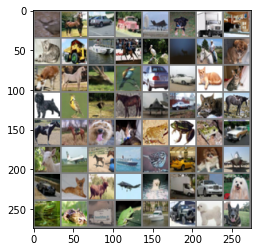

 deer horse   car truck plane   dog truck   cat   cat truck  ship horse  bird  deer horse   dog horse horse  deer  bird   car   car   cat   cat   dog  bird  bird horse plane   car   cat horse horse horse   dog   cat  frog  frog  frog   car  deer plane horse  ship  bird   car   dog plane   car   dog  deer plane   dog truck   car   dog  frog  frog truck  frog  ship truck   dog   dog


In [21]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Set first filter 
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        # He initialization:
        nn.init.kaiming_uniform_(self.conv1_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1_2.weight, mode='fan_in', nonlinearity='relu')

        # Set second filter
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_1.weight, mode='fan_in', nonlinearity='relu')

        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_2.weight, mode='fan_in', nonlinearity='relu')

        # Set third filter
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_2.weight, mode='fan_in', nonlinearity='relu')

        # Define proportion or neurons to dropout
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout4 = nn.Dropout(0.5)

        self.pool = nn.MaxPool2d((2, 2))
        
        self.fc1 = nn.Linear(2048, 128)
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_2(F.relu(self.conv1_1(x)))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2_2(F.relu(self.conv2_1(x)))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3_2(F.relu(self.conv3_1(x)))))
        x = self.dropout1(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

net = Net().to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


epoch = 100
TL = [0 for x in range(epoch)] #train loss
Tacc = [0 for x in range(epoch)] #train accuracy
VL = [0 for x in range(epoch)] #validation loss
Vacc = [0 for x in range(epoch)] #validation accuracy

for ep in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs,labels=inputs.to(device),labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        pred=outputs.argmax(dim=1,keepdim=True)
        train_acc += ((pred.eq(labels.view_as(pred)).sum().item())/(50000))

    valid_loss = 0.0
    valid_acc = 0.0
    # net.eval()     # Optional when not using Model Specific layer
    for inputs2, labels2 in testloader:
        inputs2,labels2=inputs2.to(device),labels2.to(device)
        # Forward Pass
        outputs2 = net(inputs2)
        # Find the Loss
        loss2 = criterion(outputs2,labels2)
        # Calculate Loss
        valid_loss += loss2.item()

        pred2=outputs2.argmax(dim=1,keepdim=True)
        valid_acc += ((pred2.eq(labels2.view_as(pred2)).sum().item())/(10000))

    TL[ep] = running_loss  
    Tacc[ep] = train_acc   
    VL[ep] = valid_loss
    Vacc[ep] = valid_acc

    print(f'Epoch {ep+1}/{epoch} \t Training Loss: {round(running_loss / len(trainloader),4)} \t Validation Loss: {round(valid_loss / len(testloader),4)} \t Training Accuracy: {round(train_acc,4)} \t Validation Accuracy:{round(valid_acc,4)}')

print('Finished Training')

Epoch 1/100 	 Training Loss: 1.9709 	 Validation Loss: 1.7983 	 Training Accuracy: 0.2656 	 Validation Accuracy:0.3505
Epoch 2/100 	 Training Loss: 1.6036 	 Validation Loss: 1.5234 	 Training Accuracy: 0.4053 	 Validation Accuracy:0.437
Epoch 3/100 	 Training Loss: 1.4705 	 Validation Loss: 1.4058 	 Training Accuracy: 0.4592 	 Validation Accuracy:0.4811
Epoch 4/100 	 Training Loss: 1.3747 	 Validation Loss: 1.3563 	 Training Accuracy: 0.4942 	 Validation Accuracy:0.5056
Epoch 5/100 	 Training Loss: 1.3016 	 Validation Loss: 1.2893 	 Training Accuracy: 0.5278 	 Validation Accuracy:0.5389
Epoch 6/100 	 Training Loss: 1.2417 	 Validation Loss: 1.2065 	 Training Accuracy: 0.5528 	 Validation Accuracy:0.5624
Epoch 7/100 	 Training Loss: 1.1726 	 Validation Loss: 1.1668 	 Training Accuracy: 0.5769 	 Validation Accuracy:0.5889
Epoch 8/100 	 Training Loss: 1.1212 	 Validation Loss: 1.1243 	 Training Accuracy: 0.5966 	 Validation Accuracy:0.6015
Epoch 9/100 	 Training Loss: 1.0694 	 Validation 

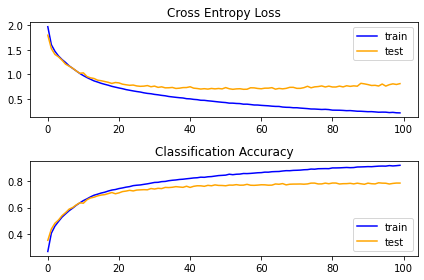

In [23]:
import sys
from matplotlib import pyplot
nTL= [x / len(trainloader) for x in TL]
nVL = [x / len(testloader) for x in VL]
# plot diagnostic learning curves
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(nTL, color='blue', label='train')
pyplot.plot(nVL, color='orange', label='test')
pyplot.legend(loc="upper right")
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(Tacc, color='blue', label='train')
pyplot.plot(Vacc, color='orange', label='test')
pyplot.legend(loc="lower right")
pyplot.tight_layout()
# save plot to file
# filename = sys.argv[0].split('/')[-1]
# pyplot.savefig(filename + '_plot.png')
# pyplot.close()

In [31]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

testloader2 = torch.utils.data.DataLoader(testset, batch_size=10000,
                                             shuffle=False, num_workers=2,
                                             prefetch_factor = 2, 
                                            pin_memory = True)
valid_acc = 0.0
# again no gradients needed
with torch.no_grad():
    for data in testloader2:
        images, labels = data 
        images,labels=images.to(device),labels.to(device)
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        
        valid_acc += ((predictions.eq(labels.view_as(predictions)).sum().item())/(10000))
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
print(f'Overall Accuracy{valid_acc*100}%')
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Overall Accuracy78.7
Accuracy for class plane is: 83.5 %
Accuracy for class car   is: 84.5 %
Accuracy for class bird  is: 71.5 %
Accuracy for class cat   is: 58.9 %
Accuracy for class deer  is: 77.5 %
Accuracy for class dog   is: 70.0 %
Accuracy for class frog  is: 84.2 %
Accuracy for class horse is: 81.3 %
Accuracy for class ship  is: 87.6 %
Accuracy for class truck is: 88.0 %
